In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import sparse
import requests
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import Normalizer
import re
from IPython.display import display

### Part 0: Load Data

In [86]:
# Load df_books and genres
wd = os.getcwd()
df_books = pd.read_csv(wd + "/data/goodreads_books.csv")
df_inferred_genres = pd.read_csv(wd + "/data/inferred_genres.csv")

# Join genres to books
df_books = pd.merge(df_books, df_inferred_genres.drop(columns="title"), how="left", on="book_id")

In [87]:
# Load sparse_reviews from file
df_reviews = sparse.load_npz(wd + "/data/user_reviews.npz")

# Load user (rows) and book (cols) indices
user_index = pd.read_csv(wd + "/data/user_index_for_sparse_matrix.csv").rename(columns={"0":"user_id"})
book_index = pd.read_csv(wd + "/data/book_index_for_sparse_matrix.csv").rename(columns={"0":"book_id"})

In [88]:
# Load my goodreads history
my_books = pd.read_csv(wd + "/data/goodreads_library_export.csv")

# Filter to books I've rated
my_books = my_books[["Book Id", "My Rating"]].rename(columns={"Book Id":"book_id", "My Rating":"rating"}).query("rating > 0")

# Reformat to fit sparse matrix
my_books = pd.merge(book_index, my_books, how="left", on="book_id").fillna(0.)
my_books = np.array(my_books["rating"]).reshape(1,-1)

# Add to sparse matrix
df_reviews = sparse.vstack([df_reviews, my_books])

# Replace 0 with 0.1 to prevent cosine similarities from zeroing
sparse_fill = 0.001
df_reviews.data[df_reviews.data == 0] = sparse_fill

### Part 1: Find Similar Users

In [89]:
### NOT WORKING AS EXPECTED -- NEED TO FIX

# Normalize reviews within users
norm = Normalizer()
df_reviews = norm.fit_transform(df_reviews) 

In [90]:
# Instantiate KNN
n_neighbors = 200
target_user = df_reviews.shape[0] - 1

nn_model = NearestNeighbors(
    metric="cosine",
    algorithm="auto",
    n_neighbors=n_neighbors,
    n_jobs=-1
)

# Fit to sparse matrix
nn_model.fit(df_reviews)

# Feed in user and get neighbors and distances
reader = df_reviews[target_user,:].toarray()
dists, neighbors = nn_model.kneighbors(reader, return_distance=True)

similar_users = pd.DataFrame(
    [pd.Series(neighbors.reshape(-1)), pd.Series(dists.reshape(-1))]).T.rename(columns={0:"user", 1:"distance"}
)

similar_users.head()

,user,distance
0,245119.0,0.000000
1,68871.0,0.804018
2,169157.0,0.809443
3,242451.0,0.827690
4,147443.0,0.831460


In [91]:
# Get all books read by similar users
book_ind = []
book_rat = []
uid = []
target_user_books = []
target_user_book_rat = []
for nt in similar_users.itertuples():
    user = df_reviews[int(nt.user),:].toarray()
    book_inds = np.where(user[0] > 0)[0]
    ratings = user[0][np.where(user[0] > 0)[0]]
    for i in range(len(book_inds)):        
        book_ind.append(book_inds[i])
        book_rat.append(ratings[i])
        uid.append(nt.user)    
        if nt.distance < 0.000000001:
            target_user_books.append(book_inds[i])
            target_user_book_rat.append(ratings[i])

neighbor_user_ratings = pd.DataFrame([uid, book_ind, book_rat]).T.rename(columns={0:"uid",1:"book_index",2:"user_rating"})

# Join overall rating for each book
neighbor_user_ratings = pd.merge(book_index.reset_index(), neighbor_user_ratings, how="inner", left_on="index", right_on="book_index")
neighbor_user_ratings = pd.merge(neighbor_user_ratings, df_books, how="inner", on="book_id")

# Filter out books target reader has already read
neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["book_index"].isin(target_user_books)]
neighbor_user_ratings.drop(["index", "book_index"], axis=1, inplace=True)

# Filter out later volumes in series using regex pattern
regex = r"#([2-9]|[1-9]\d+)"
neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex)]

# Weight user book rating by cosine similarity

# Average weighted user book rating and overall avg rating

/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_43473/3760903270.py:31: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex)]


In [92]:
# View neighbors rating table
neighbor_user_ratings.head()

,book_id,uid,user_rating,title,avg_rating,ratings_count,year,language_code,image_url,url,...,Genre_21,Genre_22,Genre_23,Genre_24,Genre_25,Genre_26,Genre_27,Genre_28,Genre_29,Genre_30
0,10016013,67816.0,0.138675,Harry Potter and the Methods of Rationality,4.38,8691.0,2015,eng,https://images.gr-assets.com/books/1293582551m...,https://www.goodreads.com/book/show/10016013-h...,...,0.007976,0.007976,0.007976,0.007976,0.007976,0.007976,0.007976,0.007976,0.007976,0.007976
1,100322,76951.0,0.123353,Assata: An Autobiography,4.47,11057.0,1999,eng,https://images.gr-assets.com/books/1328857268m...,https://www.goodreads.com/book/show/100322.Assata,...,0.005263,0.005263,0.005263,0.005263,0.005263,0.005263,0.005263,0.005263,0.005263,0.005263
2,1003311,36130.0,0.083237,Norstrilia,4.07,1505.0,1985,NaN,https://s.gr-assets.com/assets/nophoto/book/11...,https://www.goodreads.com/book/show/1003311.No...,...,0.008720,0.747108,0.008720,0.008720,0.008720,0.008720,0.008720,0.008720,0.008720,0.008720
3,1003985,69998.0,0.186052,Epic (Epic #1),3.94,5116.0,2004,eng,https://s.gr-assets.com/assets/nophoto/book/11...,https://www.goodreads.com/book/show/1003985.Epic,...,0.006362,0.006362,0.006362,0.006362,0.006362,0.006362,0.006362,0.006362,0.006362,0.006362
4,100915,83359.0,0.267860,"The Lion, the Witch, and the Wardrobe (Chronic...",4.19,1575387.0,2005,eng,https://images.gr-assets.com/books/1353029077m...,https://www.goodreads.com/book/show/100915.The...,...,0.006203,0.006203,0.006203,0.006203,0.006203,0.006203,0.006203,0.006203,0.006203,0.006203


In [93]:
# View target user's ratings
target_user_ratings = pd.DataFrame([target_user_books, target_user_book_rat]).T.rename(columns={0:"book_index",1:"user_rating"})
target_user_ratings = pd.merge(book_index.reset_index(), target_user_ratings, how="inner", left_on="index", right_on="book_index")
target_user_ratings = pd.merge(target_user_ratings, df_books, how="inner", on="book_id")
target_user_ratings.head(10)

,index,book_id,book_index,user_rating,title,avg_rating,ratings_count,year,language_code,image_url,...,Genre_21,Genre_22,Genre_23,Genre_24,Genre_25,Genre_26,Genre_27,Genre_28,Genre_29,Genre_30
0,159556,12352452,159556.0,0.084853,"Season of the Witch: Enchantment, Terror and D...",4.22,2481.0,2012,NaN,https://images.gr-assets.com/books/1329324459m...,...,0.004351,0.004351,0.004351,0.004351,0.004351,0.004351,0.004351,0.873825,0.004351,0.004351
1,222333,13166586,222333.0,0.084853,The Fish That Ate the Whale: The Life and Time...,3.97,1497.0,2012,eng,https://images.gr-assets.com/books/1327473440m...,...,0.004617,0.004617,0.004617,0.004617,0.004617,0.004617,0.004617,0.004617,0.004617,0.004617
2,270440,13554058,270440.0,0.084853,The Wandering Earth,4.01,894.0,2012,eng,https://images.gr-assets.com/books/1332444998m...,...,0.006766,0.803785,0.006766,0.006766,0.006766,0.006766,0.006766,0.006766,0.006766,0.006766
3,340694,15195,340694.0,0.113137,"The Complete Maus (Maus, #1-2)",4.53,79457.0,2003,en-GB,https://images.gr-assets.com/books/1327354180m...,...,0.006306,0.301228,0.006306,0.006306,0.006306,0.006306,0.006306,0.006306,0.006306,0.006306
4,442607,16256798,442607.0,0.056569,The One Thing: The Surprisingly Simple Truth B...,4.15,15237.0,2013,eng,https://images.gr-assets.com/books/1362177469m...,...,0.009584,0.009584,0.009584,0.009584,0.009584,0.009584,0.009584,0.009584,0.009584,0.009584
5,562115,17987621,562115.0,0.084853,The Entrepreneurial State: Debunking Public vs...,3.89,358.0,2013,NaN,https://images.gr-assets.com/books/1369818314m...,...,0.005042,0.005042,0.005042,0.005042,0.005042,0.005042,0.005042,0.005042,0.005042,0.005042
6,568445,18050143,568445.0,0.056569,"Zero to One: Notes on Startups, or How to Buil...",4.17,52400.0,2014,eng,https://images.gr-assets.com/books/1414347376m...,...,0.004848,0.004848,0.004848,0.004848,0.004848,0.004848,0.004848,0.004848,0.004848,0.004848
7,623534,18490568,623534.0,0.084853,"Age of Ambition: Chasing Fortune, Truth, and F...",4.23,3432.0,2014,eng,https://images.gr-assets.com/books/1418113377m...,...,0.004634,0.004634,0.004634,0.004634,0.004634,0.004634,0.004634,0.865622,0.004634,0.004634
8,657155,18778874,657155.0,0.056569,The Second Amendment,4.01,430.0,2014,eng,https://images.gr-assets.com/books/1397767878m...,...,0.005390,0.005390,0.005390,0.005390,0.005390,0.005390,0.005390,0.005390,0.005390,0.005390
9,754447,20588662,754447.0,0.084853,An Indigenous Peoples' History of the United S...,4.27,1225.0,2014,NaN,https://images.gr-assets.com/books/1395003842m...,...,0.006088,0.006088,0.006088,0.006088,0.006088,0.006088,0.006088,0.823436,0.006088,0.006088


In [94]:
# 20 most popular books among similar readers
popular_recs = neighbor_user_ratings.groupby(["title", "avg_rating", "ratings_count", "year"])["book_id"]\
    .count().reset_index().sort_values(by=["book_id", "avg_rating"], ascending=False)\
    .nlargest(20, "book_id").rename(columns={"book_id":"percent_similar_users_read"})

popular_recs["percent_similar_users_read"] = (popular_recs["percent_similar_users_read"] / n_neighbors).map('{:.1%}'.format)

popular_recs

,title,avg_rating,ratings_count,year,percent_similar_users_read
633,The Gunslinger,3.98,346978.0,1982,3.5%
66,Aurora,3.72,10174.0,2015,3.5%
876,"Wool Omnibus (Silo, #1)",4.24,83601.0,2012,3.0%
508,"Surely You're Joking, Mr. Feynman!: Adventures...",4.29,95353.0,1997,2.5%
649,The Hundred Thousand Kingdoms (Inheritance Tri...,3.81,30194.0,2010,2.5%
494,"Steelheart (The Reckoners, #1)",4.16,79287.0,2013,2.0%
625,The Golem and the Jinni (The Golem and the Jin...,4.10,61387.0,2013,2.0%
217,Freakonomics: A Rogue Economist Explores the H...,3.94,529274.0,2006,2.0%
371,Ninefox Gambit (The Machineries of Empire #1),3.91,3425.0,2016,2.0%
822,"Too Like the Lightning (Terra Ignota, #1)",3.87,2907.0,2016,2.0%


In [95]:
# 10 highest rated books among similar readers
highest_rated_recs = neighbor_user_ratings.groupby(["title", "avg_rating", "ratings_count", "year"])["book_id"]\
    .count().reset_index().sort_values(by=["avg_rating", "book_id"], ascending=False)\
    .nlargest(20, "avg_rating").rename(columns={"book_id":"percent_similar_users_read"})

highest_rated_recs["percent_similar_users_read"] = highest_rated_recs["percent_similar_users_read"] / n_neighbors

for i in range(n_neighbors,-1,-1):
    results = highest_rated_recs.query("percent_similar_users_read > (@i / @n_neighbors)")    
    if len(results) >= 10:
        print(i)
        break

results

0


,title,avg_rating,ratings_count,year,percent_similar_users_read
449,Saga: Book One,4.70,4201.0,2014,0.005
786,"The Way of Kings, Part 1 (The Stormlight Archi...",4.67,10191.0,2011,0.005
879,Worm,4.67,3094.0,2013,0.005
102,"Braiding Sweetgrass: Indigenous Wisdom, Scient...",4.58,1308.0,2013,0.005
664,The Last Question,4.58,215.0,2007,0.005
736,The Song of the Lioness Quartet (Song of the L...,4.58,11463.0,1997,0.005
353,"Monster Manual (Dungeons & Dragons, 5th Edition)",4.55,1382.0,2014,0.005
409,"Player's Handbook (Dungeons & Dragons, 5th Edi...",4.55,3227.0,2014,0.005
423,"Rashed, My Friend",4.53,916.0,2003,0.005
185,"Dungeon Master's Guide (Dungeons & Dragons, 5t...",4.52,1612.0,2014,0.005


In [96]:
# Best recommendations based on rating, popularity, and user similarity


In [97]:
# Filter recommendations by genre, year, popularity

In [98]:
# Recs filtered by genre

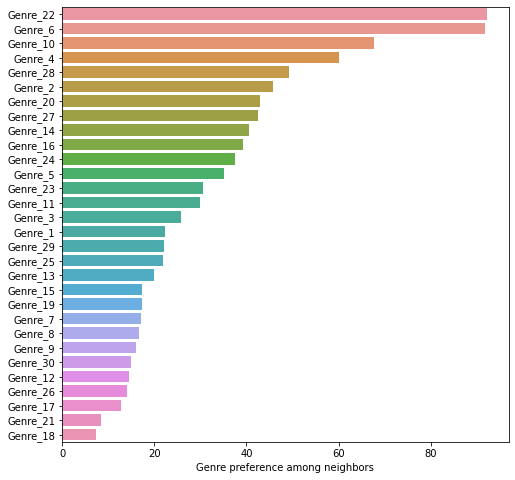

In [99]:
# Find top genres
fig, ax = plt.subplots(figsize=(8,8))
genre_ranking = pd.DataFrame(neighbor_user_ratings.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))
sns.barplot(
    data=genre_ranking,
    y=genre_ranking.index,
    x=0
)
plt.xlabel("Genre preference among neighbors")
plt.show()

In [119]:
# Loop through genres in descending relevance order and print top 5 recs
for genre in genre_ranking.index:
    
    g = float(genre[6:])
    highest_rated_recs_genre = neighbor_user_ratings.query("main_genre == @g")\
        .groupby(["title", "avg_rating", "ratings_count", "year"])["book_id"]\
        .count().reset_index().sort_values(by=["avg_rating", "book_id"], ascending=False)\
        .rename(columns={"book_id":"percent_similar_users_read"})

    highest_rated_recs_genre["percent_similar_users_read"] = highest_rated_recs_genre["percent_similar_users_read"] / n_neighbors

    print(genre)
    display(highest_rated_recs_genre[["title", "avg_rating", "ratings_count"]].head())
    print("_____\n")

Genre_22


,title,avg_rating,ratings_count
6,"Attack on Titan, Vol. 1 (Attack on Titan, #1)",4.42,87848.0
30,"Kings of the Wyld (The Band, #1)",4.42,2285.0
0,A Night Without Stars,4.41,1342.0
73,"The Foundation Trilogy (Foundation, #1-3)",4.39,73383.0
85,The Ultimate Hitchhiker's Guide to the Galaxy,4.38,225626.0


_____

Genre_6


,title,avg_rating,ratings_count
9,"Braiding Sweetgrass: Indigenous Wisdom, Scient...",4.58,1308.0
63,The Story of Human Language,4.44,394.0
59,The Rediscovery of Man: The Complete Short Sci...,4.41,711.0
6,Behave: The Biology of Humans at Our Best and ...,4.40,830.0
23,Harry Potter and the Methods of Rationality,4.38,8691.0


_____

Genre_10


,title,avg_rating,ratings_count
53,The Heart of the Buddha's Teaching: Transformi...,4.33,8114.0
16,"Extreme Alpinism: Climbing Light, Fast, and High",4.30,192.0
68,The Untethered Soul: The Journey Beyond Yourself,4.27,15849.0
3,Beyond the Mountain,4.25,342.0
7,"Creativity, Inc.: Overcoming the Unseen Forces...",4.24,27705.0


_____

Genre_4


,title,avg_rating,ratings_count
13,"Monster Manual (Dungeons & Dragons, 5th Edition)",4.55,1382.0
17,"Player's Handbook (Dungeons & Dragons, 5th Edi...",4.55,3227.0
5,"Dancer's Lament (Path to Ascendancy, #1)",4.45,1085.0
34,The War that Saved My Life (The War That Saved...,4.44,21307.0
31,The Raven and the Reindeer,4.35,974.0


_____

Genre_28


,title,avg_rating,ratings_count
24,"Rashed, My Friend",4.53,916.0
46,"The Walking Dead, Vol. 07: The Calm Before",4.28,17242.0
23,Persepolis: The Story of a Childhood (Persepol...,4.23,119470.0
18,Jinnah of Pakistan,4.22,537.0
5,"American Tabloid (Underworld USA, #1)",4.21,10342.0


_____

Genre_2


,title,avg_rating,ratings_count
23,"Sins of Empire (Gods of Blood and Powder, #1)",4.48,2567.0
12,"Injustice: Gods Among Us: Year One, Vol. 2",4.41,2470.0
3,"Berserk, Vol. 1 (Berserk, #1)",4.38,10778.0
37,The Tower of Swallows,4.33,288.0
5,"Free the Darkness (King's Dark Tidings, #1)",4.30,6591.0


_____

Genre_20


,title,avg_rating,ratings_count
3,Are Women Human? Astute and Witty Essays on th...,4.39,710.0
32,The Fire This Time: A New Generation Speaks ab...,4.35,2309.0
27,The Authoritarians,4.31,354.0
6,Beyond the Aquila Rift: The Best of Alastair R...,4.30,163.0
29,The Circular Ruins,4.30,409.0


_____

Genre_27


,title,avg_rating,ratings_count
11,Magician: Apprentice (Raymond E. Feist's Magi...,4.45,18045.0
33,"The Warded Man (Demon Cycle, #1)",4.27,3082.0
19,The Belles (The Belles #1),4.24,203.0
22,The False Prince (The Ascendance Trilogy #1),4.23,51292.0
35,"Theft of Swords (The Riyria Revelations, #1-2)",4.21,262.0


_____

Genre_14


,title,avg_rating,ratings_count
26,Saga: Book One,4.70,4201.0
0,"A Game of Thrones: The Graphic Novel, Vol. 1",4.47,25735.0
35,The Lies of Locke Lamora / Red Seas Under Red ...,4.44,710.0
5,Amory Wars: In Keeping Secrets of Silent Earth...,4.42,381.0
15,"Injustice: Gods Among Us: Year One, Vol. 1",4.35,3623.0


_____

Genre_16


,title,avg_rating,ratings_count
35,Worm,4.67,3094.0
19,Rita Hayworth and Shawshank Redemption: A Stor...,4.52,12107.0
12,Dear Martin,4.46,1566.0
3,Alias: Omnibus,4.42,1138.0
2,After Atlas,4.17,569.0


_____

Genre_24


,title,avg_rating,ratings_count
6,Bridge of Birds (The Chronicles of Master Li a...,4.30,8063.0
31,Twice Born,4.27,1509.0
10,His Master's Voice,4.11,1883.0
19,"The Amory Wars, Volume 1: The Second Stage Tur...",4.09,435.0
25,"The Forgetting (The Forgetting, #1)",3.98,4547.0


_____

Genre_5


,title,avg_rating,ratings_count
29,"The Way of Kings, Part 1 (The Stormlight Archi...",4.67,10191.0
2,Assata: An Autobiography,4.47,11057.0
7,"Dawn of Wonder (The Wakening, #1)",4.35,13351.0
16,Schindler's List,4.34,109093.0
31,We Wish to Inform You That Tomorrow We Will Be...,4.29,19564.0


_____

Genre_23


,title,avg_rating,ratings_count
1,Con đường Hồi giáo,4.36,1088.0
9,Secret Path,4.34,876.0
20,"The Walking Dead, Vol. 01: Days Gone Bye",4.29,168436.0
13,The Bird and the Sword (The Bird and the Sword...,4.27,12591.0
12,"The Air He Breathes (Elements, #1)",4.21,24098.0


_____

Genre_11


,title,avg_rating,ratings_count
13,The Clay Girl,4.42,724.0
29,You Don't Have to Say You Love Me,4.36,4478.0
6,Nick Cave: Mercy on Me,4.30,175.0
24,What Do You Care What Other People Think?,4.28,15310.0
7,Psychovertical,4.24,304.0


_____

Genre_3


,title,avg_rating,ratings_count
2,"Dungeon Master's Guide (Dungeons & Dragons, 5t...",4.52,1612.0
18,The Only Rule Is It Has to Work: Our Wild Expe...,4.24,1980.0
14,The Captain: The Journey of Derek Jeter,4.16,1085.0
13,The Best Team Money Can Buy,4.01,1282.0
1,Baseball Between the Numbers: Why Everything Y...,4.00,2947.0


_____

Genre_1


,title,avg_rating,ratings_count
13,"Senlin Ascends (The Books of Babel, #1)",4.37,1410.0
6,"Fool's Assassin (The Fitz and the Fool, #1)",4.36,16677.0
11,"My Family and Other Animals (Corfu Trilogy, #1)",4.26,20655.0
8,Jauno žmogaus memuarai: Keturiolikos laiškų ro...,4.14,251.0
16,The Sot-Weed Factor,4.08,388.0


_____

Genre_29


,title,avg_rating,ratings_count
8,Homicide: A Year on the Killing Streets,4.37,10487.0
1,"Blacksad (Blacksad, #1-3)",4.34,7361.0
10,Journey Under the Midnight Sun,4.29,321.0
17,The Private Eye,4.24,1847.0
4,Daemon (Daemon #1),4.17,9355.0


_____

Genre_25


,title,avg_rating,ratings_count
9,"Ms. Marvel, Vol. 3: Crushed",4.21,13311.0
3,Asterios Polyp,4.19,20053.0
1,"A Dirty Job (Grim Reaper, #1)",4.08,79687.0
7,I Am Malala: The Story of the Girl Who Stood U...,4.07,228884.0
16,"World Trigger, Vol. 1",4.05,584.0


_____

Genre_13


,title,avg_rating,ratings_count
14,The Last Question,4.58,215.0
17,Wonder (Wonder #1),4.43,255461.0
2,Jackalope Wives,4.35,460.0
12,The Complete Works of H.P. Lovecraft,4.34,9733.0
6,"Our Ancestors: The Cloven Viscount, The Baron ...",4.28,810.0


_____

Genre_15


,title,avg_rating,ratings_count
9,"The Walking Dead, Vol. 08: Made to Suffer",4.47,22238.0
6,"Red Sister (Book of the Ancestor, #1)",4.32,5784.0
3,"Orphan X (Orphan X, #1)",4.08,11229.0
8,"The Diabolic (The Diabolic, #1)",4.07,7457.0
2,"Monstress, Vol. 1: Awakening (Monstress, #1)",4.01,16701.0


_____

Genre_19


,title,avg_rating,ratings_count
9,"The Walking Dead, Compendium 1",4.43,58434.0
6,The Catastrophic History of You and Me,4.04,12971.0
0,"Among the Hidden (Shadow Children, #1)",3.97,96008.0
2,"Hit Man (Keller, #1)",3.90,3663.0
11,"Three Men in a Boat (Three Men, #1)",3.90,31122.0


_____

Genre_7


,title,avg_rating,ratings_count
2,I Still Believe,4.39,464.0
10,The Mysterious Stranger,4.16,5133.0
13,What I Loved,4.03,10162.0
8,The Fisherman,4.01,1458.0
0,"Fables, Vol. 20: Camelot",3.96,5574.0


_____

Genre_8


,title,avg_rating,ratings_count
9,The New Jim Crow: Mass Incarceration in the Ag...,4.49,24694.0
1,Bitch Planet #1,4.18,3120.0
0,"Animal Man, Vol. 1",4.07,4551.0
5,"Spin (Spin, #1)",4.01,26520.0
6,The Awkward Thoughts of W. Kamau Bell: Tales o...,4.01,1395.0


_____

Genre_9


,title,avg_rating,ratings_count
5,"Wool Omnibus (Silo, #1)",4.24,83601.0
2,The Rose of Winslow Street,3.95,2776.0
3,"The Shamer's Daughter (The Shamer Chronicles, #1)",3.90,4946.0
0,Burnt Offerings,3.83,2823.0
4,The Shrinking Man,3.80,3770.0


_____

Genre_30


,title,avg_rating,ratings_count
7,The Body Reader,4.17,3451.0
5,"On a Pale Horse (Incarnations of Immortality, #1)",4.14,29860.0
2,Dare Mighty Things,4.00,159.0
1,Black Falcon's Lady (Celtic Rogues #1),3.98,585.0
9,The Griever's Mark (The Griever's Mark #1),3.93,820.0


_____

Genre_12


,title,avg_rating,ratings_count
5,The High Cost of Free Parking,4.23,316.0
4,"Ms. Marvel, Vol. 2: Generation Why",4.14,17597.0
3,Mooncop,3.94,2181.0
9,You’ll Surely Drown Here If You Stay,3.91,300.0
0,100 Sideways Miles,3.84,4947.0


_____

Genre_26


,title,avg_rating,ratings_count
6,The Monster at the End of this Book,4.45,103959.0
0,Adventure Time With Fionna and Cake,4.41,2542.0
4,Lost Boy: The True Story of Captain Hook,4.20,1420.0
2,Black History In Its Own Words,4.15,190.0
3,"Burning Chrome (Sprawl, #0)",4.05,27745.0


_____

Genre_17


,title,avg_rating,ratings_count
0,"Cinder & Ella (Cinder & Ella, #1)",4.28,8801.0
7,This Immortal,3.94,7592.0
3,Kino,3.92,981.0
1,"Dumplin' (Dumplin', #1)",3.87,23974.0
6,The Good Brother: A Novel,3.73,185.0


_____

Genre_21


,title,avg_rating,ratings_count
1,The Vegetarian,3.58,573.0
0,The Undertaking of Lily Chen,3.45,2396.0


_____

Genre_18


,title,avg_rating,ratings_count
0,Very Far Away from Anywhere Else,3.86,1462.0


_____

